# Lets implement Random Forest Classifier & extra tree classifier


Import Section 


In [56]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

Lets work on the cancer dataset

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir cancerdataset
!kaggle datasets download -d amandam1/breastcancerdataset
!unzip breastcancerdataset.zip -d cancerdataset

Saving kaggle.json to kaggle.json
  0% 0.00/10.8k [00:00<?, ?B/s]
100% 10.8k/10.8k [00:00<00:00, 17.7MB/s]
Archive:  breastcancerdataset.zip
  inflating: cancerdataset/BRCA.csv  


Lets Load the dataset

In [33]:
cancerdata = pd.read_csv('/content/cancerdataset/BRCA.csv')
cancerdata.head()

,Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,15-Jan-17,19-Jun-17,Alive
1,TCGA-EW-A1OX,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,26-Apr-17,09-Nov-18,Dead
2,TCGA-A8-A079,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,08-Sep-17,09-Jun-18,Alive
3,TCGA-D8-A1XR,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,25-Jan-17,12-Jul-17,Alive
4,TCGA-BH-A0BF,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,06-May-17,27-Jun-19,Dead


Lets do some preprocessing

In [34]:
# drop duplicates
print("data before duplicate removal : ",cancerdata.shape[0])
cancerdata = cancerdata.drop_duplicates()
print("data after duplicate remomval : ",cancerdata.shape[0])


data before duplicate removal :  341
data after duplicate remomval :  335


In [35]:
# lets only take few features which are important
cancerdata = cancerdata.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,15]]
cancerdata.head()


,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Patient_Status
0,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,Alive
1,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,Dead
2,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Alive
3,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,Alive
4,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,Dead


In [36]:
# null value analysis
print(cancerdata.isnull().sum())
print("data before null remomval : ",cancerdata.shape[0])
cancerdata = cancerdata.dropna()
print("data after null remomval : ",cancerdata.shape[0])
    

Age                1
Gender             1
Protein1           1
Protein2           1
Protein3           1
Protein4           1
Tumour_Stage       1
Histology          1
ER status          1
PR status          1
HER2 status        1
Surgery_type       1
Patient_Status    14
dtype: int64
data before null remomval :  335
data after null remomval :  321


In [37]:
# lets encode the categorical features
X = cancerdata.iloc[:,:-1]
y = cancerdata.iloc[:,-1]


In [38]:
y.value_counts()

Alive    255
Dead      66
Name: Patient_Status, dtype: int64

In [39]:
features_with_noencoding = X.iloc[:,[0,2,3,4,5]]
feature_with_ordinal_encoding = X.iloc[:,[6]]
feature_with_one_hot_encoding = X.iloc[:,[1,7,8,9,10,11]]
feature_with_ordinal_encoding.Tumour_Stage = feature_with_ordinal_encoding.Tumour_Stage.map({'I':1,"II":2,"III":3})

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [40]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
feature_with_one_hot_encoding = enc.fit_transform(feature_with_one_hot_encoding).toarray()
feature_with_one_hot_encoding = pd.DataFrame(feature_with_one_hot_encoding,columns = enc.get_feature_names_out())
feature_with_one_hot_encoding


,Gender_FEMALE,Gender_MALE,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,ER status_Positive,PR status_Positive,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
317,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
318,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
319,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [41]:
feature_with_one_hot_encoding.shape

(321, 13)

In [42]:
X = pd.concat([features_with_noencoding.reset_index(drop = True), feature_with_ordinal_encoding.reset_index(drop = True),feature_with_one_hot_encoding.reset_index(drop = True)], axis=1)
X.shape
y = y.map({"Alive":0,"Dead":1}).reset_index(drop=True)

In [44]:
X

,Age,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Gender_FEMALE,Gender_MALE,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,ER status_Positive,PR status_Positive,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
0,36.0,0.080353,0.42638,0.54715,0.273680,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,43.0,-0.420320,0.57807,0.61447,-0.031505,2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,69.0,0.213980,1.31140,-0.32747,-0.234260,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,56.0,0.345090,-0.21147,-0.19304,0.124270,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,56.0,0.221550,1.90680,0.52045,-0.311990,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,36.0,0.231800,0.61804,-0.55779,-0.517350,3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
317,44.0,0.732720,1.11170,-0.26952,-0.354920,2,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
318,61.0,-0.719470,2.54850,-0.15024,0.339680,2,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
319,79.0,0.479400,2.05590,-0.53136,-0.188480,1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [45]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42, n_jobs = -1)
X, y = smt.fit_resample(X, y)

In [48]:
y.value_counts()


0    248
1    248
Name: Patient_Status, dtype: int64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


# Lets apply random forest

In [53]:
rf_clf = RandomForestClassifier()
param_grids = {'n_estimators' : [60,65,70,75,80,85,90,95],'criterion' : ['gini', 'entropy'],'max_depth' : [15,17,19,20,22,24,25]}
rf_clf = GridSearchCV(estimator = rf_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
rf_clf.fit(X_train,y_train)
rf_clf.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=70; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)

In [54]:
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=85)

accuracy score : 0.8389261744966443
f1 score : 0.84
auc score : 0.8932971014492754
log loss : 0.4148046550510598
classification report : 
               precision    recall  f1-score   support

           0       0.78      0.90      0.84        69
           1       0.90      0.79      0.84        80

    accuracy                           0.84       149
   macro avg       0.84      0.84      0.84       149
weighted avg       0.85      0.84      0.84       149

*********** confusion matrx ***********


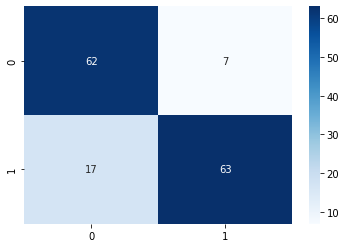

In [57]:
y_pred = rf_clf.predict(X_test)
y_prob = rf_clf.predict_proba(X_test)[:,[1]]
print("accuracy score :",accuracy_score(y_test,y_pred))
print("f1 score :",f1_score(y_test,y_pred))
print("auc score :",roc_auc_score(y_test,y_prob))
print("log loss :",log_loss(y_test,y_prob))
print('classification report : \n', classification_report(y_test,y_pred))
print('*********** confusion matrx ***********')
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')

# Lets apply Extra tree classifier

In [58]:
extratree_clf = ExtraTreesClassifier()
param_grids = {'n_estimators' : [60,65,70,75,80,85,90,95],'criterion' : ['gini', 'entropy'],'max_depth' : [15,17,19,20,22,24,25]}
extratree_clf = GridSearchCV(estimator = extratree_clf,param_grid = param_grids,cv = 5, scoring = 'accuracy', verbose = 2)
extratree_clf.fit(X_train,y_train)
extratree_clf.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=60; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=65; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n_estimators=70; total time=   0.1s
[CV] END ......criterion=gini, max_depth=15, n

ExtraTreesClassifier(criterion='entropy', max_depth=19, n_estimators=90)

ExtraTreesClassifier(criterion='entropy', max_depth=19, n_estimators=90)

In [59]:
extratree_clf = ExtraTreesClassifier(criterion='entropy', max_depth=19, n_estimators=90)
extratree_clf.fit(X_train,y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=19, n_estimators=90)

accuracy score : 0.8456375838926175
f1 score : 0.8516129032258064
auc score : 0.9185688405797101
log loss : 0.3677057861223974
classification report : 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84        69
           1       0.88      0.82      0.85        80

    accuracy                           0.85       149
   macro avg       0.85      0.85      0.85       149
weighted avg       0.85      0.85      0.85       149

*********** confusion matrx ***********


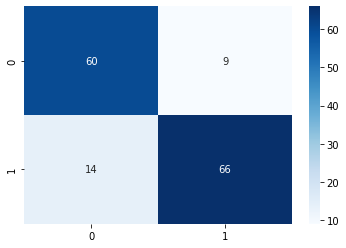

In [60]:
y_pred = extratree_clf.predict(X_test)
y_prob = extratree_clf.predict_proba(X_test)[:,[1]]
print("accuracy score :",accuracy_score(y_test,y_pred))
print("f1 score :",f1_score(y_test,y_pred))
print("auc score :",roc_auc_score(y_test,y_prob))
print("log loss :",log_loss(y_test,y_prob))
print('classification report : \n', classification_report(y_test,y_pred))
print('*********** confusion matrx ***********')
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True, cmap = 'Blues')